In [1]:
import sys
sys.path.append('./python_util')
import glob
import pickle
from collections import defaultdict, Counter

import numpy as np
from tqdm import tqdm

from simulation import Simulation

In [3]:
import warnings
warnings.filterwarnings('ignore')

## 1. Prepare experimental UMI count density

### 1.1. organize read count data into #UMI per probe per gene per barcode format
The pickle file has been generated by `extract_reads_per_umi_per_barcode.py`.

In [4]:
# The size of this pickle file can be very large. I ran this jupyter-notebook on a computer with 16GB of memory.
path = '' # "out_dir" argument passed to "parse_bam_file" in "extract_reads_per_umi_per_barcode.py"
result = pickle.load(open(f'{path}/Cp_BHI_no_housekeeping.pkl', 'rb'))
umi_probe_gene_barcode = defaultdict(lambda: defaultdict(lambda: defaultdict(Counter)))

for barcode, barcode_dict in tqdm(result['corrected_umi'].items()):    
    for (umi, probe), count in barcode_dict.items():
        gene = '_'.join(probe.split('_')[:-1])
        probe_ind = int(probe.split('_')[-1])  
        umi_probe_gene_barcode[barcode][gene][probe_ind][umi] += count

100%|██████████| 282091/282091 [01:56<00:00, 2429.06it/s]  


### 1.2. make a (density) histogram of no. of reads associated with a UMI, keeping up to 8

In [8]:
def collect_statistics(gene_dict):
    result = {
        #'num_unique_umis': 0,
        'total_counts': [],
    }
    
    for i, (gene, probe_dict) in enumerate(gene_dict.items()):
        for probe, count_dict in probe_dict.items():
            #num_unique_umi = len(list(count_dict.keys()))
            count_list = list(count_dict.values())
            #result['num_unique_umis'] += num_unique_umi
            result['total_counts'] += count_list      
            
    return result

total_count_upto_8 = []
for i, (barcode, gene_dict) in tqdm(enumerate(umi_probe_gene_barcode.items())):
    result = collect_statistics(gene_dict)
    total_reads = result['total_counts']
    umi_count = Counter(total_reads)
    umi_count_upto_8 = [umi_count.get(num, 0) for num in range(1, 9)]
    total_count_upto_8.append(umi_count_upto_8)
    
total_count_upto_8 = np.array(total_count_upto_8)
density = total_count_upto_8.sum(axis=0) / total_count_upto_8.sum()

282091it [00:14, 19875.52it/s] 


## 2. Run simulation

In [28]:
# the higher the following numbers, the more accurate the normalization factor will be. 
pcr_sim = Simulation(
    density_exp=density,
    n_transcript=100, 
    n_pcr_trial=10,
    n_subsampling_trial=10,
    p=0.8, # copy success probability during PCR
)

### 2.1. simulate in-droplet PCR where spurious UMI gets incorporated along with the forward 10X primer

Starting 6 cycles of ingem (in-droplet) PCR
ingem (in-droplet) PCR ended


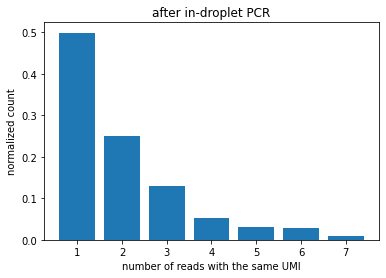

In [29]:
pcr_sim.simulate_ingem_pcr()
pcr_sim.plot('post_ingem')

## 2.2. simulate normal, out-of-droplet PCR 

Starting 10 of 16 cycles of out-of-droplet PCR
out-of-droplet PCR ended


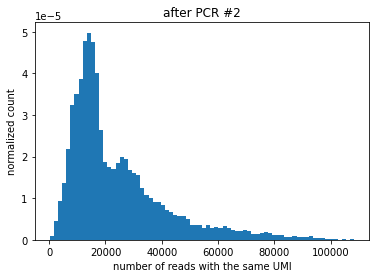

In [30]:
pcr_sim.simulate_normal_PCR()
pcr_sim.plot('post_pcr')

### 2.3. sweep over subsampling parameter ($r$) range 

The purpose of `sweep_r` is to eye-ball a good initial guess for `fit_r` function in the next section. Please play around with the range until you see a clear local minimum. The range may vary depending on the sequencing depth.

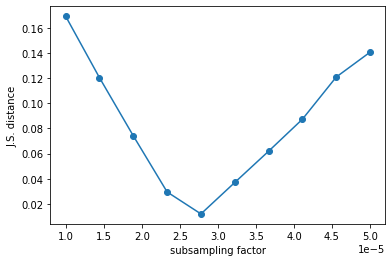

In [26]:
pcr_sim.sweep_r(low_r=1e-5, high_r=5e-5)

For Cp_BHI experiment (excluding housekeeping genes---see `extract_reads_per_umi_per_barcode.py` for the list of probe index), 2.7e-5 seems to be a good initial guess.

In [34]:
pcr_sim.fit_r(initial_r=2.6e-05, n_opt_trial=2)

In [35]:
print(pcr_sim.opt_result)
print(pcr_sim.r) # mean of pcr_sim.opt_result['r']

{'dist': [0.005258026205375191, 0.006824600205486169], 'r': [2.782939453125e-05, 2.8592462158278803e-05]}
2.82109283447644e-05


In [36]:
pcr_sim.calculate_normalization_factor()

In [37]:
print(pcr_sim.normalization_factor) # this number will vary a little bit due to sampling during simulation

7.1444


This means that the a given UMI(=transcript) was duplicated(via spurious UMI incorporated during in-droplet PCR) in average of 7.XXX times. So the count matrix of this experiment needs to be divided by 7.XXX. 